In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 05: Lecture

## Implementation of Perceptron

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

In [2]:
###-----------------
### import statement
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
###----------------------------------
### Basic Parameters for housekeeping
###----------------------------------

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'
# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.coolwarm
plt.rcParams.update(params);
plt.set_cmap(CMAP);


TEST_SIZE = 0.2 # Test size

EPOCHS = 1000  # number of epochs

ALPHA = 0.01  # learning rate


<Figure size 1500x600 with 0 Axes>

## Generate Data Set
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.

In [4]:
X, y = datasets.make_moons(n_samples=1000, 
                           noise = 0.2, 
                           random_state=RANDOM_STATE)

In [5]:
# create a DataFrame
data_df = pd.DataFrame(X, columns=  ['x1', 'x2'])
data_df['target'] = y
data_df.head()

x1        x2  target
0  0.906340  0.902676       0
1 -1.115368  0.755793       0
2  1.887692  0.417597       1
3 -0.933450 -0.022999       0
4 -0.968729  0.063963       0

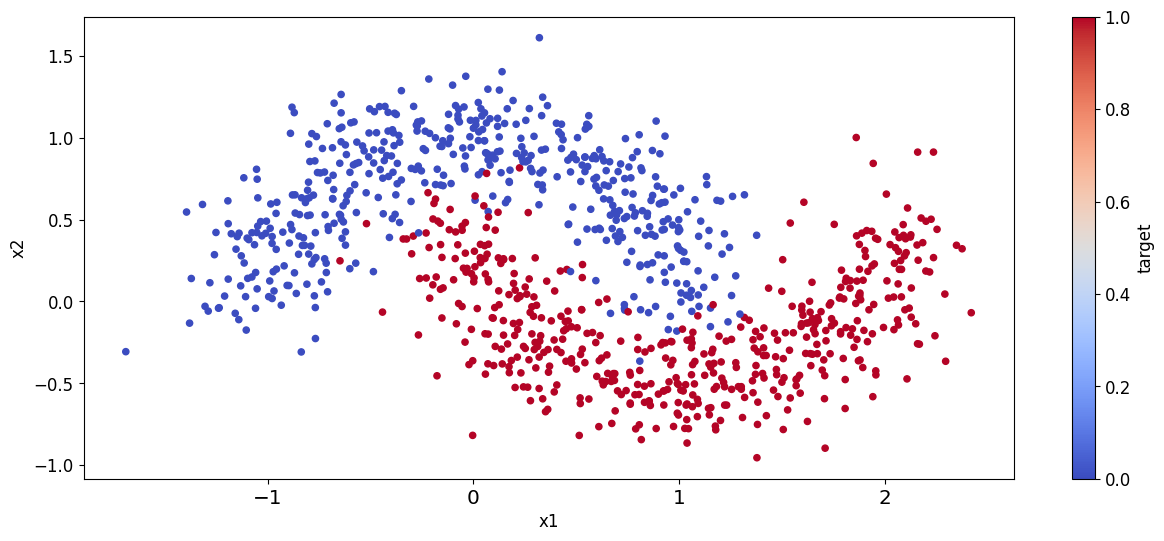

In [6]:
# Plot Scatter
data_df.plot(x = 'x1', y = 'x2', kind = 'scatter', c = 'target', cmap = CMAP);

In [7]:
# Split the data
data_train, data_test = data_df.values[:900], data_df.values[900:]
data_train.shape, data_test.shape

((900, 3), (100, 3))

## Over to Perceptron

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in previous lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
<p>
As we know that adjustments in the weights are simply (a-$\hat{y}$). Hence we will be adjusting weights by learning_rate * (a-$\hat{y}$). 
</p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant and we will circle back to learning_rate after some sessions.
</p>
</div>

# A function to make predictions
def predict(row, weights):
    z = weights[0] # Initialize with b, bias
    for i in range(len(row)-1):
        z += weights[i + 1] * row[i] # and weights are added here to the values
    return 1 if z >=0  else 0 # simplest form of activation function

In [8]:
def predict(row, wt):
    '''
    Args:
        row: one row from the dataframe (x1, x2, target)
        wt: weights to be used for prediction (w0, w1, w2)
    '''
    
    # z = W.X + b
    ###------------------
    z = wt[0] #w0
    
    for i in range (len(row)-1):
        
        z += wt[i+1]* row[i]
    #print (z)
    ###-----------------    
    return 1 if z >=0 else 0 # simplest form of activation function

**Unit Test** : Its advisable to test the function.

In [9]:
weights = [0.1, 2.0, 1.0]

predict(data_df.loc[0], weights)

1

In [10]:
data_df.loc[0]

0.1 + 0.906340*2 + 0.902676*1.0

2.8153560000000004

## Back-propagation - Estimate Perceptron weights
$
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
$
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$


In [11]:
def train_weights(train, alpha, n_epoch):
    '''
    Args:
        train: np.ndarray - training data
        alpha: float- learning rate
        n_epoch : number of epochs
    '''
    
    errors =[]
    
    weights = np.random.rand(train.shape[1])
    
    m = train.shape[0]
    
    for epoch in range(n_epoch): # loop for numbe rof epochs
        sum_error = 0.0
        for row in train:
            
            pred = predict(row, weights)
            
            dz = pred - row[-1] # a-y
            
            error = (pred - row[-1])**2
            
            sum_error = sum_error + error
            
            weights[0] = weights[0] - alpha * dz /m
            
            for i in range (len(row)-1):
                
                weights[i+1] = weights[i+1] - alpha * dz * row[i]/m
                
            #print (weights)
            
        errors.append(sum_error)
    
    return errors, weights

In [12]:
errors, weights = train_weights(data_train, 
                                alpha = ALPHA, 
                                n_epoch = EPOCHS)
weights

array([-4.91888502e-06,  1.96260734e-05, -3.67686263e-05])

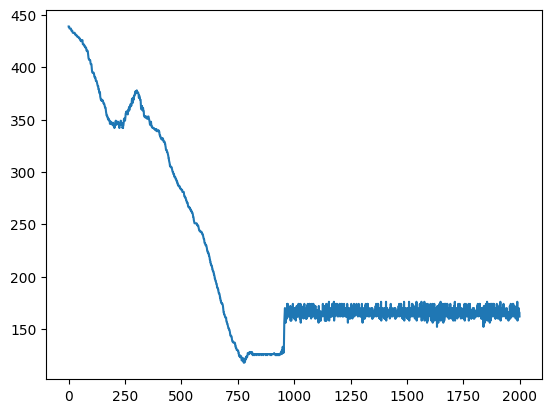

In [13]:
fig, ax = plt.subplots()

ax.plot(errors)

## Predictions

### Train Set

y_pred = []
for row in data_train.to_numpy():
    prediction = predict(row, weights)    
    y_pred.append(prediction)
accuracy_score(data_train['target'], y_pred)

In [14]:
# predict by row and append to y_pred

y_pred = []

for row in data_train:
    pred = predict(row, weights)
    y_pred.append(pred)

y_pred
# calculate accuracy
accuracy_score(data_train[:, -1], y_pred)

0.8466666666666667

### Test Set

Also for test set
y_pred = []

for row in data_test.to_numpy():
    prediction = predict(row, weights)
    y_pred.append(prediction)
accuracy_score(data_test['target'], y_pred)

In [15]:
# predict by row and append to y_pred

y_pred = []

for row in data_test:
    pred = predict(row, weights)
    y_pred.append(pred)

y_pred
# calculate accuracy
accuracy_score(data_test[:, -1], y_pred)

0.89

In [16]:
cm = confusion_matrix(data_test[:, -1], y_pred)
cm

array([[54,  4],
       [ 7, 35]])

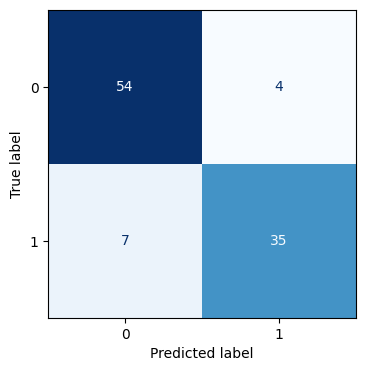

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();

In [18]:
# range of two columns
x_min, x_max  = X[:, 0].min()- 0.01, X[:, 0].max()+ 0.01
y_min, y_max  = X[:, 1].min()- 0.01, X[:, 1].max()+ 0.01

dm = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))

XX = np.c_[xx.ravel(), yy.ravel()]

XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )


y_pred = []
    
for row in (XX):
    y_p = predict(row, weights)
    y_pred.append(y_p)
        
Z = np.array(y_pred).reshape(xx.shape)

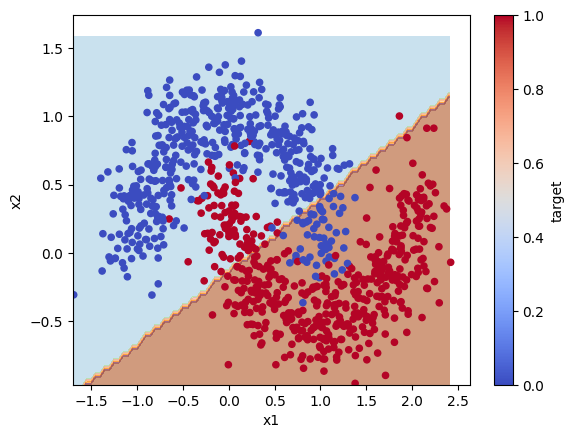

In [19]:
fig, ax = plt.subplots()

ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)

data_df.plot(x = 'x1', y = 'x2', 
             kind = 'scatter', ax = ax,
             c = 'target', cmap = CMAP);
        

In [20]:
def fn_plot_decision_boundary(X):
    
    fig, ax = plt.subplots();
    
    dm = 0.05
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    XX = np.c_[xx.ravel(), yy.ravel()]

    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
    
    
    y_pred = []
    
    for row in (XX):

        y_p = predict(row, weights)
        y_pred.append(y_p)
        
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2],
                                  s=30, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

In [21]:
fn_plot_decision_boundary(data_train.to_numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

## A note on Loss Function
In logistic regression we are looking for if it is correct class or not. For example, we want to know if there is a car in the picture or not.
    
Mathematically speaking:

$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.<br>

Alternatively:

If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.  

if there is **no** car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.  

We can summarize two equation as:

$p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$

Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.

Taking log of above equation:

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$

Since we aim to minimize above function, add negative sign and our loss function becomes

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

We want to sum it up for all samples in the dataset. Hence:

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
### Derivative of sigmoid function
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
